In [1]:
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


2022-12-16 20:00:00.956493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Transformation data features

In [65]:
di = {chr(i + 1040): i + 1 for i in range(32)} 
di.update({" ": 0})
inverted_d = {value: key for key, value in di.items()}
len_full_name = 36  # max full name length

def  string_to_num(character_string, flag=True):
    character_list = list(character_string)
    character_numbers = [di[item] for item in character_list]

    if flag:
        while len(character_numbers) < len_full_name:
            character_numbers.append(0)

    return character_numbers

def num_to_string(character_numbers):
    return [inverted_d.get(item, "_") for item in character_numbers]

In [66]:
def transform_features(features,
                       ind_slice=None, flag=None, reshape_flag=True,
                       gray_flag=True, normal_flag=False):
    features = features.as_numpy_iterator()
    if gray_flag:
        lst_to_crop = [rgb2gray(item) for item in features]
    else:
        lst_to_crop = [item for item in features]

    if flag == "val":
        features = np.array(lst_to_crop[ind_slice:], dtype=np.float64)
    elif flag == "train":
        features = np.array(lst_to_crop[:ind_slice], dtype=np.float64)
    else:
        features = np.array(lst_to_crop, dtype=np.float64)

    if reshape_flag:
        n, nx, ny = features.shape
        features = features.reshape((n, nx * ny))

    if normal_flag:
        norm = tf.keras.layers.Rescaling(scale=1.0 / 255.0)
        features = norm(features)

    return features

In [67]:
def reverse_flat_categories(array, initial_shape):
    res = tf.keras.layers.Reshape((initial_shape[1], initial_shape[2]))

    return np.argmax(res(array), axis=2)


def reverse_flat_continuous(array, initial_shape):
    res = tf.keras.layers.Reshape((initial_shape[1], initial_shape[2]))

    return res(array)

Upload data

In [72]:
with open("labels_train.txt") as f:
    dt = f.read().split("\n")
    labels = np.array(list(map(string_to_num, dt)), dtype=np.int64)

with open("labels_valid.txt") as f:
    extra_dt = f.read().split("\n")
    extra_labels = np.array(list(map(string_to_num, extra_dt)), dtype=np.int64)

In [78]:
img_height = 224
img_width = 224
entry_features = tf.keras.utils.image_dataset_from_directory(
    'TrainData',
    image_size=(img_height, img_width), interpolation="bicubic",
    batch_size=None, shuffle=False, labels=None)
extra_entry_features = tf.keras.utils.image_dataset_from_directory(
    "ValidData",
    image_size=(img_height, img_width), interpolation="bicubic",
    batch_size=None, shuffle=False, labels=None)
extra_eval_data = tf.keras.utils.image_dataset_from_directory(
    "DataForOCR",
    image_size=(img_height, img_width), interpolation="bicubic",
    batch_size=None, shuffle=False, labels=None)

Found 14 files belonging to 1 classes.
Found 3 files belonging to 1 classes.
Found 10 files belonging to 1 classes.


In [74]:
combined_features_dataset = entry_features.concatenate(extra_entry_features)
tf_features = tf.convert_to_tensor(transform_features(combined_features_dataset,
                                                      reshape_flag=False,
                                                      gray_flag=False, normal_flag=True))
tf_labels = tf.convert_to_tensor(np.concatenate((labels, extra_labels), axis=0))

In [75]:
cat_label_group = tf.keras.utils.to_categorical(tf_labels, num_classes=33)
cat_label_group_shape = cat_label_group.shape
flat = tf.keras.layers.Flatten()
flat_label_group = flat(cat_label_group)

Training

In [76]:
def train_model(model,
                feature_set, epochs, label_set,
                validation_split, batch_size=None):
    history = model.fit(x=feature_set, y=label_set, batch_size=batch_size,
                        epochs=epochs, shuffle=True,
                        validation_split=validation_split)
    epochs = history.epoch

    hist = pd.DataFrame(history.history)
    mse1, mse2, acc1, acc2 = hist["loss"], hist["val_loss"],\
                             hist["accuracy"], hist["val_accuracy"]

    return epochs, mse1, mse2, acc1, acc2

In [77]:
def plot_the_loss_curve(epochs, mse1, mse2):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(epochs, mse1, label="Training")
    plt.plot(epochs, mse2, label="Validation")
    plt.legend()
    plt.show()


def plot_accuracy(epochs, acc1, acc2):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epochs, acc1, label="Training")
    plt.plot(epochs, acc2, label="Validation")
    plt.legend()
    plt.show()

In [79]:
def construct_model(set_learning_rate, output_dims=60, inp_shape=(500, 500, 3)):
    model = tf.keras.models.Sequential()

    # VGG-16 like
    model.add(tf.keras.layers.Conv2D(input_shape=inp_shape,
                                     filters=64, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same",
                                     activation="tanh"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=4096, activation="relu"))
    model.add(tf.keras.layers.Dense(units=4096, activation="relu"))
    model.add(tf.keras.layers.Dense(units=output_dims,
                                    activation="softmax"))

    model.compile(optimizer=tf.keras.optimizers.Adadelta(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=tf.keras.metrics.Accuracy())

    return model

In [80]:
learning_rate = 0.9999
epochs = 30
batch_size = 9
validation_split = 0.1

new_fit = construct_model(
    learning_rate,
    output_dims=flat_label_group.shape[1],
    inp_shape=(img_height, img_width, 3)
)
epochs, mse1, mse2, acc1, acc2 = train_model(model=new_fit,
                                             feature_set=tf_features,
                                             epochs=epochs,
                                             label_set=flat_label_group,
                                             batch_size=batch_size,
                                             validation_split=validation_split)

Epoch 1/30
2/2 [==============================] - 64s 23s/step - loss: 255.0027 - accuracy: 0.0000e+00 - val_loss: 254.3550 - val_accuracy: 0.0000e+00
Epoch 2/30
2/2 [==============================] - 47s 21s/step - loss: 254.5617 - accuracy: 0.0000e+00 - val_loss: 254.0297 - val_accuracy: 0.0000e+00
Epoch 3/30
2/2 [==============================] - 43s 19s/step - loss: 254.1201 - accuracy: 0.0000e+00 - val_loss: 253.6787 - val_accuracy: 0.0000e+00
Epoch 4/30
2/2 [==============================] - 45s 19s/step - loss: 253.6513 - accuracy: 0.0000e+00 - val_loss: 253.2814 - val_accuracy: 0.0000e+00
Epoch 5/30
2/2 [==============================] - 37s 17s/step - loss: 253.1209 - accuracy: 0.0000e+00 - val_loss: 252.8043 - val_accuracy: 0.0000e+00
Epoch 6/30
2/2 [==============================] - 35s 17s/step - loss: 252.4814 - accuracy: 0.0000e+00 - val_loss: 252.2118 - val_accuracy: 0.0000e+00
Epoch 7/30
2/2 [==============================] - 48s 28s/step - loss: 251.7009 - accuracy: 0.

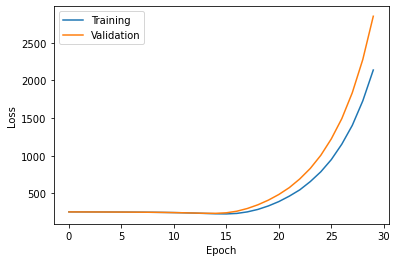

In [81]:
plot_the_loss_curve(epochs, mse1, mse2)

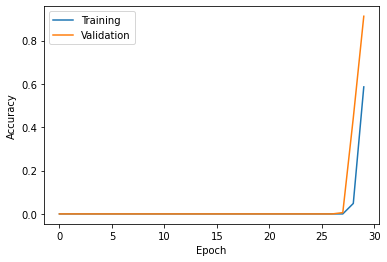

In [82]:
plot_accuracy(epochs, acc1, acc2)

In [83]:
new_fit.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [84]:
out = new_fit.predict(
    x=tf.convert_to_tensor(transform_features(
        extra_eval_data,
        reshape_flag=False,
        gray_flag=False,
        normal_flag=True
    )),
)

1/1 [==============================] - 7s 7s/step


In [86]:
print(list(map(
    lambda x: ''.join(num_to_string(x)),
    reverse_flat_categories(out, cat_label_group_shape)
)))

['САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ', 'САКАЕОВ АВААТААРС  ИНОВАЕ           ']
